# Credits
This notebook has taken inferences from few of the notebooks, Main notebook is directly based off of the format [here][1].
Lonnie's notebook [here][2] helped me to figure out about the tflite format.

[1]: https://www.kaggle.com/code/mayukh18/gislr-feature-data
[2]: https://www.kaggle.com/code/lonnieqin/isolated-sign-language-recognition-with-dnn

In [1]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# IMPORTS

In [2]:
print("\n... PIP INSTALLS STARTING ...\n")
!pip install -q --upgrade tensorflow-io
try:
    import mediapipe as mp
except:
    !pip install -q mediapipe
    import mediapipe as mp
print("\n... PIP INSTALLS COMPLETE ...\n")

!pip install lion-tf
print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")
# Competition Specific Imports (You'll see why we need these later)
# mediapipe above

# Machine Learning and Data Science Imports (basics)
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_io as tfio; print(f"\t\t– TENSORFLOW-IO VERSION: {tfio.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");

# Built-In Imports (mostly don't worry about these)
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from glob import glob
import Levenshtein
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print("\n\n... IMPORTS COMPLETE ...\n")


... PIP INSTALLS STARTING ...

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

... PIP INSTALLS COMPLETE ...

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:0000:01
  Created wheel for lion-tf: filename=lion_tf-0.0.1-py3-none-any.whl size=3128 sha256=2eeaf8757b88ee51b84e82c02dbcdd0d8a3b0ccfb9cd2e7c38a854252c8c3236
  Stored in directory: /root/.cache/pip/wheels/b2/8a/8d/9a0be2470440010954105496dd04d09502b09b51191fd4b9a2
Successfully built lion-tf
  Attempting uninstall: protobuf


# SETUP

### HELPER FUNCTIONS

In [3]:
def read_json_file(file_path):
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")


ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

### LOAD DATA

In [4]:
# Define the path to the root data directory
DATA_DIR         = "/kaggle/input/asl-signs"

print("\n... BASIC DATA SETUP STARTING ...\n")
print("\n\n... LOAD TRAIN DATAFRAME FROM CSV FILE ...\n")

train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
train_df["path"] = DATA_DIR+"/"+train_df["path"]
display(train_df)

print("\n\n... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...\n")
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)
print(s2p_map)



... BASIC DATA SETUP STARTING ...



... LOAD TRAIN DATAFRAME FROM CSV FILE ...



,path,participant_id,sequence_id,sign
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie
...,...,...,...,...
94472,/kaggle/input/asl-signs/train_landmark_files/5...,53618,999786174,white
94473,/kaggle/input/asl-signs/train_landmark_files/2...,26734,999799849,have
94474,/kaggle/input/asl-signs/train_landmark_files/2...,25571,999833418,flower
94475,/kaggle/input/asl-signs/train_landmark_files/2...,29302,999895257,room




... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...

{'tv': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, '

# PREPROCESSING

The preprocessing cells need to match the same cells as the feature generation.

<AxesSubplot:>

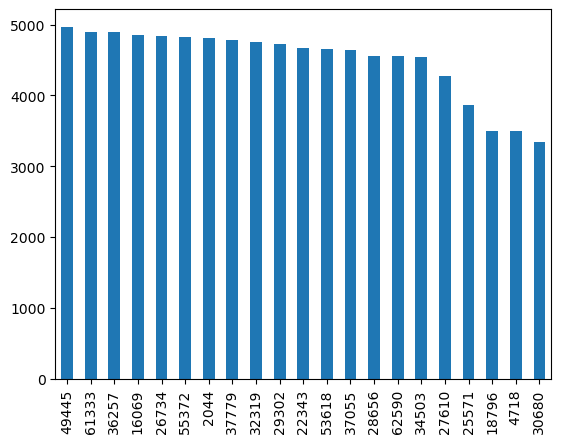

In [75]:
train_df.participant_id.value_counts().plot(kind="bar")

In [77]:
train_df["sign"].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64

## Configuration

In [5]:
#Dropping Z-axis
DROP_Z = False

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if DROP_Z:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*2)
else:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE[1]
    

84


## Helper Functions

In [6]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out


## TensorFlow Feature Preprocessing Layer

The FeatureGen class is defined to create a custom layer for a TensorFlow-based neural network. It inherits functionalities from tf.keras.layers.Layer and initializes the object using the constructor method, ensuring proper initialization of the inherited attributes and methods from the superclass. This class can then be used to define custom behaviors for feature generation within a neural network architecture.

In [84]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

print(FeatureGen()(tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")))
FeatureGen()(load_relevant_data_subset(train_df.path[0]))

KerasTensor(type_spec=TensorSpec(shape=(1, 5796), dtype=tf.float32, name=None), name='feature_gen_1/concat_5:0', description="created by layer 'feature_gen_1'")


<tf.Tensor: shape=(1, 5796), dtype=float32, numpy=
array([[ 5.18924236e-01,  3.42620254e-01,  1.48732506e-05, ...,
         6.35599867e-02,  5.70323110e-01, -1.20788895e-01]], dtype=float32)>

In [92]:
FeatureGen()(load_relevant_data_subset(train_df.path[0]))

<tf.Tensor: shape=(1, 5796), dtype=float32, numpy=
array([[ 5.18924236e-01,  3.42620254e-01,  1.48732506e-05, ...,
         6.35599867e-02,  5.70323110e-01, -1.20788895e-01]], dtype=float32)>

In [85]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [119]:
def create_feature_image(feature_data, title, cmap="coolwarm"):
    # Calculate the minimum and maximum values of the feature data
    min_val = tf.reduce_min(feature_data)
    max_val = tf.reduce_max(feature_data)
    
    # Normalize and scale feature values
    feature_data_norm = (feature_data - min_val) / (max_val-min_val)

    
    # Create an empty image with appropriate dimensions
    image = np.zeros((feature_data_norm.shape[0], feature_data_norm.shape[1], 3), dtype=np.uint8)

    # Convert feature values to color-coded representation
    image[:, :, 0] = feature_data_norm * 255
    image[:, :, 1] = 255 - (feature_data_norm * 255)

    # Convert image to BGR format for OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    # Add title to the image
    cv2.putText(image, title, (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return image



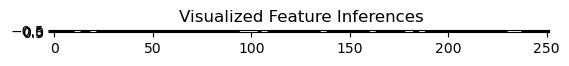

In [120]:

def visualize_feature_inferences(input_data):
    # Extract key features from the input data
    features = FeatureGen()(input_data)

    # Separate features into individual arrays
    means = features[:, :LANDMARKS]
    stds = features[:, LANDMARKS:2*LANDMARKS]
    normalized_means = features[:, 2*LANDMARKS:3*LANDMARKS]

    # Create and display images for each feature
    mean_image = create_feature_image(means, "Means", cmap="viridis")
    std_image = create_feature_image(stds, "Standard Deviations", cmap="inferno")
    normalized_mean_image = create_feature_image(normalized_means, "Normalized Means", cmap="plasma")

    # Combine feature images into a single composite image
    composite_image = np.hstack([mean_image, std_image, normalized_mean_image])

    # Display the composite image
    plt.imshow(composite_image)
    plt.title("Visualized Feature Inferences")
    plt.show()

# Load input data
input_data = load_relevant_data_subset(train_df.path[0])

# Visualize feature inferences
visualize_feature_inferences(input_data)

# TRAIN

##### Hyperparameters
BATCH_SIZE = 256
VAL_PCT = 0.1
LEARNING_RATE = 0.000333
LR_PATIENCE = 2
LR_REDUCTION_FACTOR = 0.8
EPOCHS = 50

STARTING_LAYER_SIZE = 1024
DROPOUTS = [0.4, 0.4]


In [47]:
train_x    = np.load("/kaggle/input/gislr-feature-data-on-the-shoulders/feature_data.npy").astype(np.float32)
train_y    = np.load("/kaggle/input/gislr-feature-data-on-the-shoulders/feature_labels.npy").astype(np.uint8)
print(train_x.shape, train_y.shape)
if DROP_Z:
    train_x = np.reshape(train_x, [train_x.shape[0], -1, 3])
    train_x = train_x[:, :, 0:2]
    train_x = np.reshape(train_x, [train_x.shape[0], -1])
    print(train_x.shape, train_y.shape)

N_TOTAL = train_x.shape[0]
FLAT_FRAME_SHAPE = train_x.shape[1]
assert(FLAT_FRAME_SHAPE == FLAT_INPUT_SHAPE)
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

#random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
#train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=7)
fold=0
for i, (train_index, test_index) in enumerate(skf.split(train_x,train_y)):
    print(f"Fold {i}:")
    if i==fold:
        #print(train_index)
        val_x_fold, val_y_fold = train_x[test_index], train_y[test_index]
        train_x_fold, train_y_fold = train_x[train_index], train_y[train_index]

train_x_fold.shape


(94477, 5796) (94477,)
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:


(80980, 5796)

Importing kerastuner.tuners

In [48]:

from keras_tuner.tuners import RandomSearch, BayesianOptimization
from lion_tf import Lion

In [122]:
import tensorflow as tf

#Neural Network Implementation
def fc_block(inputs, output_channels, dropout, activation="gelu"):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    # Additional layers can be added here
    x = tf.keras.layers.Dense(output_channels // 2)(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    return x

In [69]:
def build_model(hp):
    #Here we set the hyperparameters for the search   
    STARTING_LAYER_SIZE = hp.Int(name="STARTING_LAYER_SIZE", min_value=1024, max_value=1554, step=32)
    dropout = [hp.Float(name="dropout1", min_value=0.20, max_value=0.40, step=0.02),   
               hp.Float(name="dropout2", min_value=0.20, max_value=0.40, step=0.02)]
    DROPOUTS_len= 2
    hp_activation = hp.Choice('hp_activation', values=["gelu", "relu"])
    hp_learning_rate = hp.Choice('hp_learning_rate', values=[LEARNING_RATE,LEARNING_RATE*0.7, LEARNING_RATE*0.9])
    
    hp_optimizer = hp.Choice('optimizer', values=['adam'])

    if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp_learning_rate)
    def get_model(n_labels=250, init_fc=STARTING_LAYER_SIZE, flat_frame_len=FLAT_FRAME_SHAPE):
        _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
        x = _inputs

        # Define layers
        
        for i in range(DROPOUTS_len):
            x = fc_block(
                x, output_channels=init_fc//(2**i), 
                dropout=dropout[i]
            )

        # Define output layer
        _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

        # Build the model
        model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
        return model

    model = get_model()
    model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
    model.summary()
    return model
    

In [70]:
#Hyperparameter tuning
tuner = BayesianOptimization(
    build_model,
    objective='val_acc',
    max_trials=20,
    executions_per_trial=1,
    directory='/',
    project_name='asl',
    
)

ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5796)

In [53]:
!mkdir models
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, factor=LR_REDUCTION_FACTOR, verbose=1)
]
#history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=EPOCHS, callbacks=cb_list, batch_size=BATCH_SIZE)
#model.save("./models/asl_model")

In [54]:
#We are looking for hyperparameters. Note that I only use 10 epochs, the number of epochs can be increased
search=False
if search:
    tuner.search(train_x_fold, train_y_fold, epochs=50, validation_data=(val_x_fold, val_y_fold), callbacks=cb_list, batch_size=BATCH_SIZE)

In [55]:
if search:
    best_hps = tuner.get_best_hyperparameters()[0].values
    print('The best hyperparameters:',best_hps)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 5796)]            0         
                                                                 
 dense_76 (Dense)            (None, 1426)              8266522   
                                                                 
 batch_normalization_32 (Bat  (None, 1426)             5704      
 chNormalization)                                                
                                                                 
 activation_60 (Activation)  (None, 1426)              0         
                                                                 
 dropout_60 (Dropout)        (None, 1426)              0         
                                                                 
 dense_77 (Dense)            (None, 713)               1017451   
                                                          

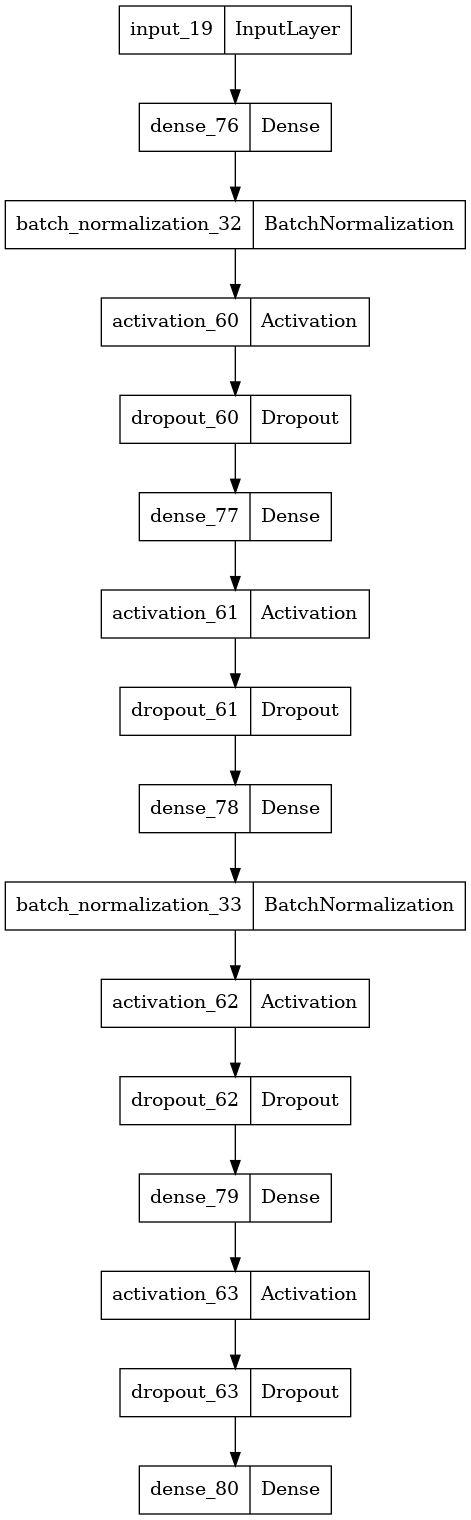

In [58]:
if search:
    STARTING_LAYER_SIZE = best_hps['STARTING_LAYER_SIZE']
    dropout = [best_hps['dropout1'],best_hps['dropout2']]
    DROPOUTS_len= 2#best_hps['dropouts_len']
    hp_activation=best_hps['hp_activation']
    hp_learning_rate=best_hps['hp_learning_rate']
    hp_optimizer=best_hps['optimizer']
else:
    #0.7616174221038818
    STARTING_LAYER_SIZE = 1024#1024
    dropout = [0.3,0.3]
    DROPOUTS_len= 2#3
    hp_activation='gelu' #'relu'
    hp_learning_rate=0.000333#LEARNING_RATE
    hp_optimizer='adam'#'adam'
    
    
if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
elif hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(hp_learning_rate)    
    
def get_model(n_labels=250, init_fc=STARTING_LAYER_SIZE, flat_frame_len=FLAT_FRAME_SHAPE):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs

    # Define layers

    for i in range(DROPOUTS_len):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=dropout[i]
        )
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)

    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
model.summary()
tf.keras.utils.plot_model(model)

In [63]:
import gc
gc.collect()
# folds=[0,1,2,3,4,5]
folds=[0,1]
models=[]
histories=[]
for fold in folds:
    print(f"Fold {fold}:")
    cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=LR_PATIENCE, factor=LR_REDUCTION_FACTOR, verbose=1)]
    for i, (train_index, test_index) in enumerate(skf.split(train_x,train_y)):
        if i==fold:
            val_x_fold, val_y_fold = train_x[test_index], train_y[test_index]
            train_x_fold, train_y_fold = train_x[train_index], train_y[train_index]
        
    model = get_model()
    if hp_optimizer == 'lion':
        optimizer = Lion(hp_learning_rate)
    elif hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(hp_learning_rate)    
    model.compile(optimizer, "sparse_categorical_crossentropy", metrics="acc")
    #model.summary()
    #tf.keras.utils.plot_model(model)
    history = model.fit(train_x_fold, train_y_fold, validation_data=(val_x_fold, val_y_fold), epochs=50, callbacks=cb_list, batch_size=BATCH_SIZE)#
    histories.append(history)
    model.save(f"./models/asl_model_{fold}")
    
    #model.evaluate(val_x_fold, val_y_fold)
    #for x,y in zip(val_x_fold[:10], val_y_fold[:10]):
    #    print(f"PRED: {decoder(np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0), axis=-1)[0]):<20} – GT: {decoder(y)}")
    models.append(model)
    gc.collect()

Fold 0:
Epoch 1/50
633/633 [==============================] - 9s 10ms/step - loss: 5.0263 - acc: 0.0301 - val_loss: 4.5383 - val_acc: 0.0619 - lr: 3.3300e-04
Epoch 2/50
633/633 [==============================] - 5s 8ms/step - loss: 3.9611 - acc: 0.1120 - val_loss: 3.9604 - val_acc: 0.1225 - lr: 3.3300e-04
Epoch 3/50
633/633 [==============================] - 5s 8ms/step - loss: 3.4155 - acc: 0.1882 - val_loss: 3.5613 - val_acc: 0.1822 - lr: 3.3300e-04
Epoch 4/50
633/633 [==============================] - 5s 8ms/step - loss: 3.0751 - acc: 0.2518 - val_loss: 3.4250 - val_acc: 0.1907 - lr: 3.3300e-04
Epoch 5/50
633/633 [==============================] - 5s 8ms/step - loss: 2.8469 - acc: 0.2972 - val_loss: 3.4704 - val_acc: 0.1810 - lr: 3.3300e-04
Epoch 6/50
633/633 [==============================] - 5s 8ms/step - loss: 2.6624 - acc: 0.3354 - val_loss: 2.8821 - val_acc: 0.3044 - lr: 3.3300e-04
Epoch 7/50
633/633 [==============================] - 5s 8ms/step - loss: 2.5070 - acc: 0.3673 - 

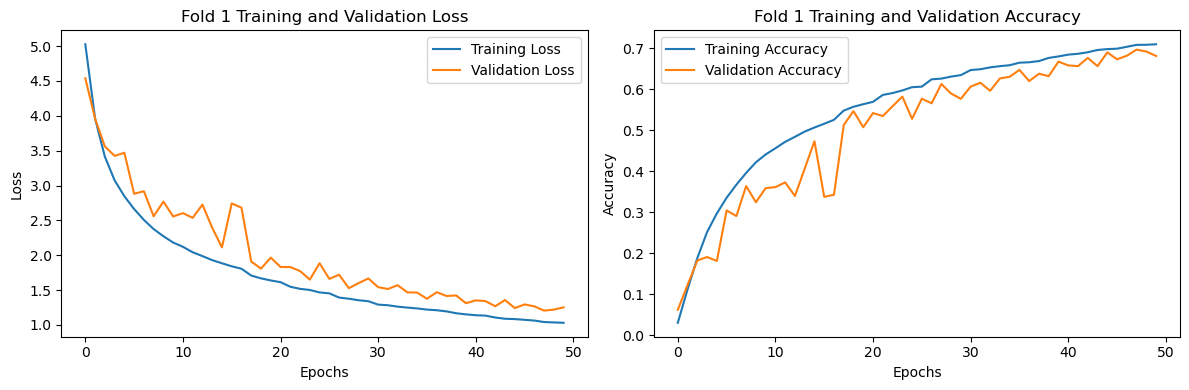

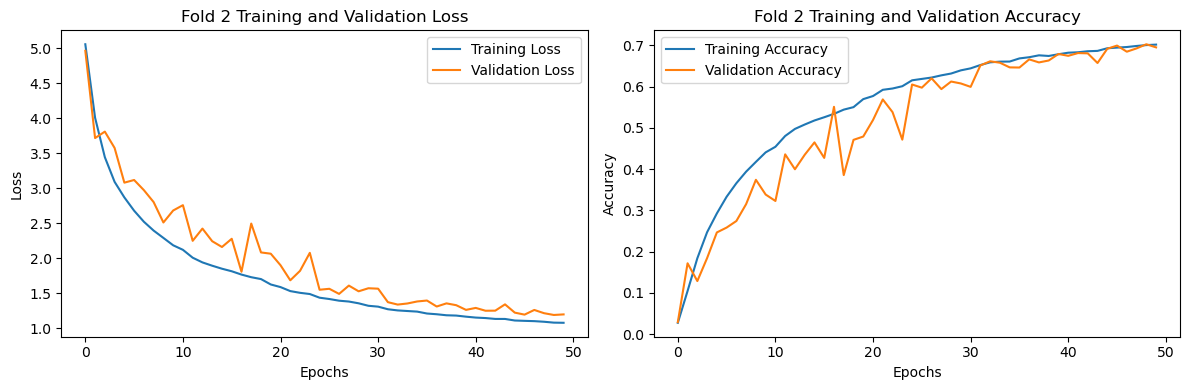

In [64]:
import matplotlib.pyplot as plt

# Plot training history for each fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Generate TFLite Model

In [27]:
class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ASL model 
    """

    def __init__(self, asl_models):
        """
        Initializes the TFLiteModel with the specified feature generation model and main model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = FeatureGen()
        self.asl_models   = asl_models
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs=[]
        for asl_model in self.asl_models:
            outputs.append(asl_model(x)[0, :])
        outputs = tf.keras.layers.Average()(outputs)
        #print(outputs)
        # Return a dictionary with the output tensor
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(models)#Due to model size limitations, I only take the 3 with the best CV
demo_output = tflite_keras_model(load_relevant_data_subset(train_df.path[0]))["outputs"]
decoder(np.argmax(demo_output.numpy(), axis=-1))

'blow'

In [28]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
keras_model_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/models/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/models/model.tflite

!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(train_df.path[0]))
sign = np.argmax(output["outputs"])

print("PRED : ", decoder(sign))
print("GT   : ", train_df.sign[0])

  adding: kaggle/working/models/model.tflite (deflated 36%)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.2 MB/s eta 0:00:00a 0:00:01m
PRED :  blow
GT   :  blow
